
图像分类是根据图像的语义信息将不同类别图像区分开来，是计算机视觉中重要的基本问题

猫狗分类属于图像分类中的粗粒度分类问题

![](https://ai-studio-static-online.cdn.bcebos.com/1cd9ef37036647c2afbbc866a7d2c14179f33cf1e2494d1f8f00de556d231452)


**首先导入必要的包**

paddle--->PaddlePaddle深度学习框架

os------------->python的模块，可使用该模块对操作系统进行操作

numpy---------->python第三方库，用于进行科学计算

PIL------------> Python Image Library,python第三方图像处理库

matplotlib----->python的绘图库 pyplot:matplotlib的绘图框架

os------------->提供了丰富的方法来处理文件和目录

sys------------->供对解释器使用或维护的一些变量的访问，以及与解释器强烈交互的函数。

pickle---------->模块实现了基本的数据序列和反序列化

In [1]:
# 
# 导入需要的包
import paddle
import numpy as np
from PIL import Image
import sys
import matplotlib.pyplot as plt
import os
import sys 
import pickle
print("本教程基于Paddle的版本号为："+paddle.__version__)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


本教程基于Paddle的版本号为：2.2.2


# **Step1:准备数据**
**（1）数据集介绍**

我们使用CIFAR10数据集。CIFAR10数据集包含60,000张32x32的彩色图片，10个类别，每个类包含6,000张。其中50,000张图片作为训练集，10000张作为验证集。这次我们只对其中的猫和狗两类进行预测。

![](https://ai-studio-static-online.cdn.bcebos.com/567016c028714d21bfe690dee70e9ea31512ba3575bd4d7caebbb7ade05c72ac)

**(2)train_reader和test_reader**

自定义读取器处理训练集和测试集

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [2]:
#解压数据集
!tar -zxvf /home/aistudio/data/data9154/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
#定义数据序列化函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print(unpickle("cifar-10-batches-py/data_batch_1").keys())
print(unpickle("cifar-10-batches-py/test_batch").keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [4]:
'''
自定义数据集
'''
from paddle.io import Dataset
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, mode='train'):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        if mode == 'train':
            xs=[]
            ys=[]
            self.data = []
            self.label = []
            #批量读入数据
            for i in range(1,6):
                train_dict=unpickle("cifar-10-batches-py/data_batch_%d" % (i,))
                xs.append(train_dict[b'data'])
                ys.append(train_dict[b'labels'])
            #拼接数据
            Xtr = np.concatenate(xs)
            Ytr = np.concatenate(ys)
            #数据归一化处理
            for (x,y) in zip(Xtr,Ytr):  
                x= x.flatten().astype('float32')/255.0
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
        else:
            self.data = []
            self.label = []
            #读入数据
            test_dict=unpickle("cifar-10-batches-py/test_batch")
            X=test_dict[b'data']
            Y=test_dict[b'labels']
            for (x,y) in zip(X,Y):  
                #数据归一化处理
                x= x.flatten().astype('float32')/255.0
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        #返回单一数据和标签
        data = self.data[index]
        label = self.label[index]
        #注：返回标签数据时必须是int64
        return data, np.array(label, dtype='int64')
    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        #返回数据总数
        return len(self.data)

# 测试定义的数据集
train_dataset = MyDataset(mode='train')
eval_dataset = MyDataset(mode='val')
print('=============train_dataset =============')
#输出数据集的形状和标签
print(train_dataset.__getitem__(1)[0].shape,train_dataset.__getitem__(1)[1])
#输出数据集的长度
print(train_dataset.__len__())
print('=============eval_dataset =============')
#输出数据集的形状和标签
for data, label in eval_dataset:
    print(data.shape, label)
    break
#输出数据集的长度
print(eval_dataset.__len__())

=============train_dataset =============
(3072,) 9
50000
=============eval_dataset =============
(3072,) 3
10000


# **Step2.网络配置**

**（1）网络搭建**

*** **CNN网络模型**

在CNN模型中，卷积神经网络能够更好的利用图像的结构信息。下面定义了一个较简单的卷积神经网络。显示了其结构：输入的二维图像，先经过三次卷积层、池化层和Batchnorm，再经过全连接层，最后使用softmax分类作为输出层。

![](https://ai-studio-static-online.cdn.bcebos.com/98b9b702cce040fb8a874e28eae6d34ace6025a2c9444cdd954ab5f14d69cfdc)

**池化**是非线性下采样的一种形式，主要作用是通过减少网络的参数来减小计算量，并且能够在一定程度上控制过拟合。通常在卷积层的后面会加上一个池化层。paddlepaddle池化默认为最大池化。是用不重叠的矩形框将输入层分成不同的区域，对于每个矩形框的数取最大值作为输出

**BatchNorm2D**顾名思义是对每batch个数据同时做一个norm。作用就是在深度神经网络训练过程中使得每一层神经网络的输入保持相同分布的。

In [5]:
#定义CNN网络
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv0 = paddle.nn.Conv2D(in_channels=3, out_channels=20, kernel_size=5, padding=0)
        self.pool0 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self._batch_norm_0 = paddle.nn.BatchNorm2D(num_features = 20)

        self.conv1 = paddle.nn.Conv2D(in_channels=20, out_channels=50, kernel_size=5, padding=0)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self._batch_norm_1 = paddle.nn.BatchNorm2D(num_features = 50)

        self.conv2 = paddle.nn.Conv2D(in_channels=50, out_channels=50, kernel_size=5, padding=0)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self.fc1 = paddle.nn.Linear(in_features=50, out_features=10)
    
    def forward(self,input):
        #将输入数据的样子该变成[1,3,32,32]
        input = paddle.reshape(input,shape=[-1,3,32,32])
        x = self.conv0(input)
        x = paddle.nn.functional.relu(x)
        x = self.pool0(x)
        x = self._batch_norm_0(x)

        x = self.conv1(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool1(x)
        x = self._batch_norm_1(x)

        x = self.conv2(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        y = paddle.nn.functional.softmax(x)
        return y

# **Step3.模型训练 and Step4.模型评估**

In [6]:

#step3:训练模型
# 用Model封装模型
model = paddle.Model(MyCNN())
# 定义损失函数
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),paddle.nn.CrossEntropyLoss(),paddle.metric.Accuracy(topk=(1,5)))
# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')
# 启动模型全流程训练
model.fit(train_dataset,            # 训练数据集
           eval_dataset,            # 评估数据集
          epochs=5,            # 总的训练轮次
          batch_size = 256,    # 批次计算的样本量大小
          shuffle=True,             # 是否打乱样本集
          verbose=1,                # 日志展示格式
          save_dir='./chk_points/', # 分阶段的训练模型存储路径
          callbacks=[visualdl])     # 回调函数使用
#保存模型
model.save('model_save_dir')

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 196/196 [==============================] - loss: 1.9184 - acc_top1: 0.4471 - acc_top5: 0.8701 - 227ms/step         
save checkpoint at /home/aistudio/chk_points/0
Eval begin...
step 40/40 [==============================] - loss: 2.1211 - acc_top1: 0.4971 - acc_top5: 0.8878 - 64ms/step        
Eval samples: 10000
Epoch 2/5
step 196/196 [==============================] - loss: 1.9054 - acc_top1: 0.5787 - acc_top5: 0.9300 - 226ms/step         
save checkpoint at /home/aistudio/chk_points/1
Eval begin...
step 40/40 [==============================] - loss: 1.9921 - acc_top1: 0.5557 - acc_top5: 0.9294 - 62ms/step        
Eval samples: 10000
Epoch 3/5
step 196/196 [==============================] - loss: 1.8879 - acc_top1: 0.6295 - acc_top5: 0.9456 - 225ms/step         
save checkpoint at /home/aistudio/chk_points/2
Eval begin...
step 40/40 [==============================] - loss: 2.1130 - acc_top1: 0.5763 - acc_top5: 0.9267 - 62ms/step        
Eval samples: 10000
Epoch 4/5
step 196/196 

In [7]:
def load_image(file):
        #打开图片
        im = Image.open(file)
        #将图片调整为跟训练数据一样的大小  32*32，设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.ANTIALIAS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        #矩阵转置 
        im = im.transpose((2, 0, 1))                               
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0
        #print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


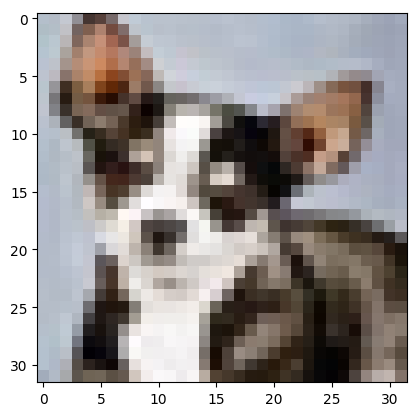

im_shape的维度： (1, 3, 32, 32)
Predict begin...
step 1/1 [==============================] - 3ms/step
Predict samples: 3
results [(array([[1.0379372e-04, 4.1628674e-09, 9.1696584e-01, 2.9961688e-03,
        4.3390114e-06, 7.9838350e-02, 1.0598869e-05, 8.0849051e-05,
        1.7790647e-08, 1.4289981e-08]], dtype=float32),)]
infer results: bird


In [8]:
#定义标签列表
label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]
#读入测试图片并展示
infer_path='/home/aistudio/data/data7940/dog.png'
img = Image.open(infer_path)
plt.imshow(img)   
plt.show()    



#载入要预测的图片
infer_img = load_image(infer_path)
#将图片变为数组
infer_img=np.array(infer_img).astype('float32')
#进行预测
result = model.predict(infer_img)
#输出预测结果
print('results',result)
print("infer results: %s" % label_list[np.argmax(result[0][0])])  



